# Using Machine Learning to predict a topological invariant of superconductors

In this code we use machine learning (ML) methods to predict the topological invariant Bott index of disordered superconductors. If the Bott index is nonzero, the superconductor is topologically nontrivial and hosts Majorana quasiparticles. These Majorana states are known for their potential to be a building bloch for quantum computing. The precise calculation of the Bott index demands high computational resources. If we are able to predict this index using a ML method, we can save time and computational resources. 

The input data is extracted from Green's functions of the superconductors which I computed using a Fortran code. For each value of the chimical potential (denoted 'mu') and magnetic dilution (denoted 'p'), we have data of several realizations of superconductors. Our goal is to build the topological phase diagram of the Bott index ('B') as a function of mu and p. We know the Bott index for p=0, which we will use to train different ML models.

## Load data

In the following we load the data for p=0, which we will use to train different ML models. We also load the data whose labels we will predict. We have data for mu ranging from -7 to 0 and p ranging from 0 to 1. Then, later we will recover the full phase diagram, which is known from the reference [Phys. Rev. B 100, 235102 (2019)].

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

####################################################################################################
#LOAD THE DATA TO BE TRAINED
X = np.loadtxt("p0_varymu_square/Data/ALDOStxy.out") #features, the LDOS
mu_train = np.loadtxt("p0_varymu_square/Data/Amup.out")[:,0]
p_train = np.loadtxt("p0_varymu_square/Data/Amup.out")[:,1]
sample_size=len(X)

y_t=np.zeros(sample_size) #labels

mu_c1=-4-math.sqrt(4-(1.2**2))
mu_c2=-4+math.sqrt(4-(1.2**2))
mu_c3=-math.sqrt(4-(1.2**2))
mu_c4=0

for mu_i in range(sample_size):
    if (mu_train[mu_i]>=mu_c1) and (mu_train[mu_i]<=mu_c2):
        y_t[mu_i]=-1
    if (mu_train[mu_i]>=mu_c3) and (mu_train[mu_i]<=mu_c4):
        y_t[mu_i]=2


####################################################################################################
#LOAD THE DATA WHOSE LABELS WE WILL PREDICT
N_folders=10
for fold_i in range(N_folders):
    if (fold_i==0):
        X_predict = np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/ALDOStxy.out") #features to predict a label
        mu_predict = np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,0]
        p_predict = np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,1]
    else:
        X_predict=np.concatenate((X_predict,np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/ALDOStxy.out")),axis=0)
        mu_predict=np.concatenate((mu_predict,np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,0]))
        p_predict=np.concatenate((p_predict,np.loadtxt("varyp_varymu_square"+str(fold_i+1)+"/Data/Amup.out")[:,1]))

N_mu=len(np.unique(mu_predict))
N_p=len(np.unique(p_predict))
N_grid=N_mu*N_p
N_d=int(len(mu_predict)/N_grid)
Nd_mu_p=N_d

####################################################################################################
#DEFINING DOMES OF THE DATA WHOSE LABELS WE WILL PREDICT
dome1 = np.array([[mu_c1,0],[-4,0.48],[mu_c2,0]]) 
fit_dome1 = np.poly1d(np.polyfit(dome1[:,0],dome1[:,1], 2))

dome2 = np.array([[mu_c3,0],[0,0.48],[-mu_c3,0]]) 
fit_dome2 = np.poly1d(np.polyfit(dome2[:,0],dome2[:,1], 2))

#The Bott index should be finite below these domes and vanish above them according to [Phys. Rev. B 100, 235102 (2019)].

The variable X is the set of features and contains the local density of states (LDOS) of many superconductors. The variable y_t contains the corresponding labels, which are the Bott indexes. The Bott index is an integer number. We will use X and y_t to train the models. Then, we use the models to predict the labels of X_predict.

Before training ML models, let's visualize the LDOS for disorderless (p=0) data for B=0,-1 and 2, respectively.

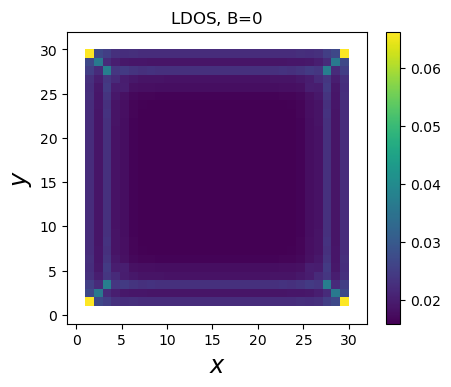

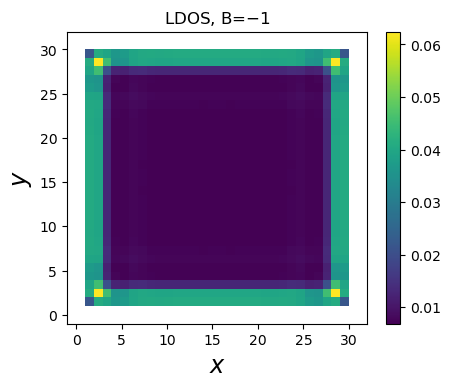

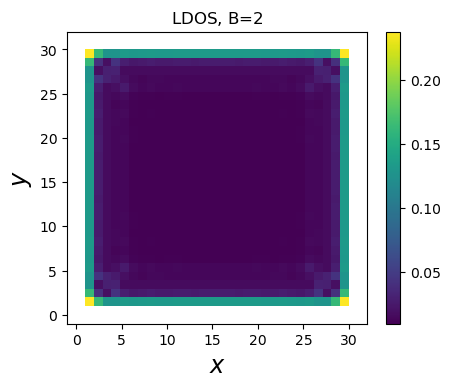

In [2]:
import math 
Bot=[0,-1,2]
LDOSa = X[np.where(mu_train==-2)]
LDOSb = X[np.where(mu_train==-5)]
LDOSc = X[np.where(mu_train==0)]
LDOS2=np.vstack((LDOSa,LDOSb,LDOSc))

nx=int(math.sqrt(len(X[0])))
ny=nx

LDOS=np.zeros((nx,ny))

for idd in range(3) :
    ii=-1
    for iy in range(ny) :
        for ix in range(nx) :
            ii+=1
            LDOS[ix,iy]=LDOS2[idd,ii] 

    plt.figure(figsize=(5,4))
    plt.imshow(np.transpose(LDOS[:,:]),extent=[1,nx,1,ny], aspect='auto',origin='lower') 
    plt.colorbar()
    plt.title('LDOS'+', B=${}$'.format(Bot[idd]), loc='center')
    plt.xlabel('$x$', fontsize='xx-large')
    plt.ylabel("$y$", fontsize='xx-large')
    plt.xlim(-2+1,nx+1+1)
    plt.ylim(-2+1,ny+1+1)
    plt.subplots_adjust(left=0.15)  
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('Data/fLDOS{}.png'.format(idd+1))  

From the figures above, we note that when the superconductor is topological (B=-1 and B=2), the LDOS is more intense at the edges. In the following, we train ML models to predict the label B.

## Train a classification model, validate and make predictions

Here, we split the dataset X into training and testing sets. Next, we consider a LogisticRegression classification model. We then define the function 'Predict_Classification', which validates the model and predicts the label of X_predict.

In [3]:
y=np.ravel(y_t)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

from sklearn.linear_model import LogisticRegression
reg = 0.01 # Set regularization rate
model = LogisticRegression(C=1/reg, solver='lbfgs', multi_class='auto', max_iter=10000).fit(X_train, y_train)

def Predict_Classification(model2,X_test2,y_test2):
    
    validate = model2.predict(X_test2)
    
    from sklearn.metrics import classification_report 
    print(classification_report(y_test2, validate))
    
    
    Bott_all2=np.zeros((N_mu,N_p,N_d)) 
    Bott_density2=np.zeros((N_mu,N_p))  
    Bott_tt = model2.predict(X_predict) 
    
    for i_mu,mu_i in enumerate(np.unique(mu_predict)):
        for i_p,p_i in enumerate(np.unique(p_predict)):
            var=np.intersect1d(np.where(mu_predict==mu_i),np.where(p_predict==p_i)) 
            Bott_t = Bott_tt[var]
            Bott_density2[i_mu,i_p]=Bott_t.mean()
            Bott_all2[i_mu,i_p,:]=Bott_t[:] 
    return Bott_density2,Bott_all2


Bott_density,Bott_all=Predict_Classification(model,X_test,y_test) 

              precision    recall  f1-score   support

        -1.0       1.00      0.97      0.98        98
         0.0       0.96      0.99      0.97        70
         2.0       0.98      1.00      0.99        43

    accuracy                           0.98       211
   macro avg       0.98      0.99      0.98       211
weighted avg       0.98      0.98      0.98       211



Remarkably, the accuracy of the model is close to 1.00 in the test dataset.  

### Plot figures

Here we present figures with the predictions of the ML models. The first figure is the topological phase diagram, which show the average Bott index as a function of mu and p. Other figures show, for fixed values of mu, the percentage of each Bott index value as a function of p.

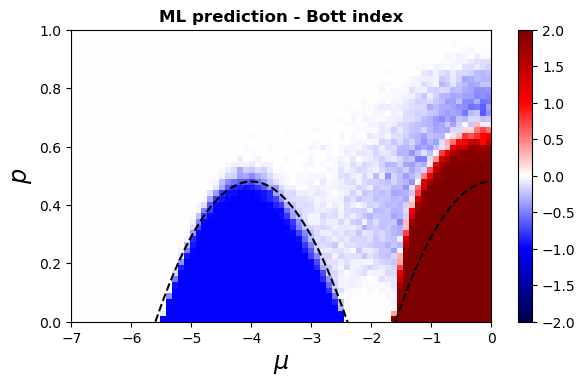

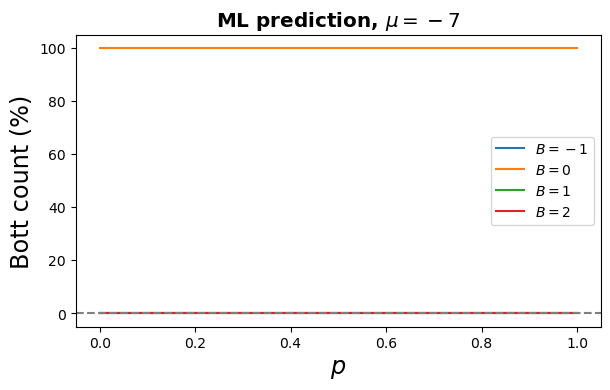

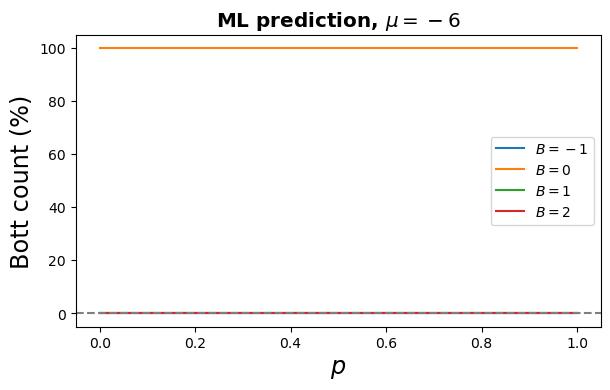

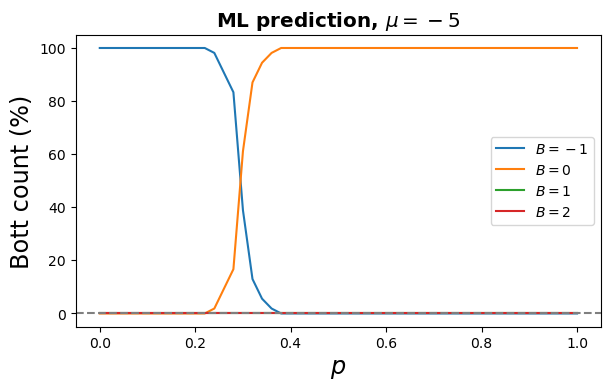

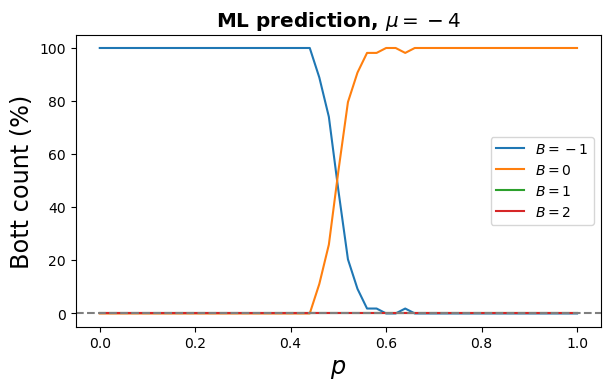

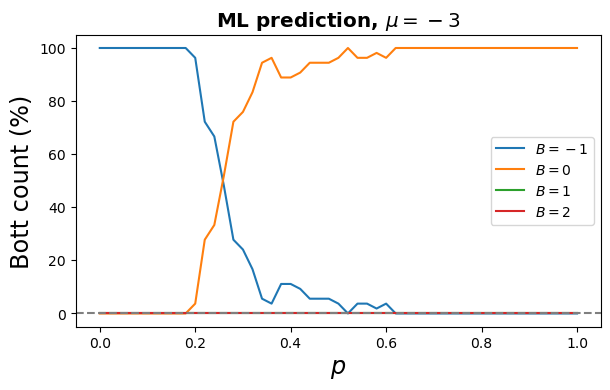

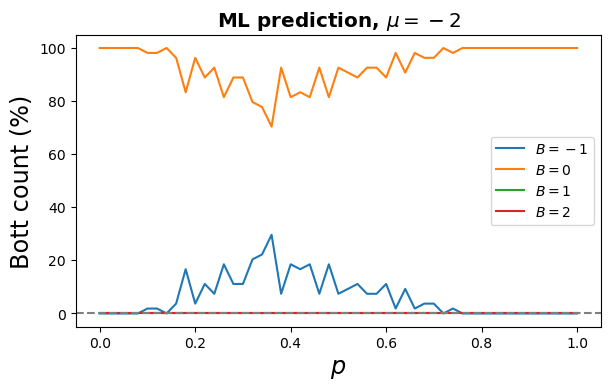

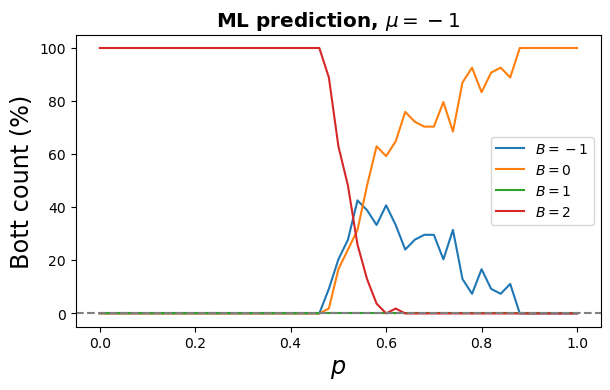

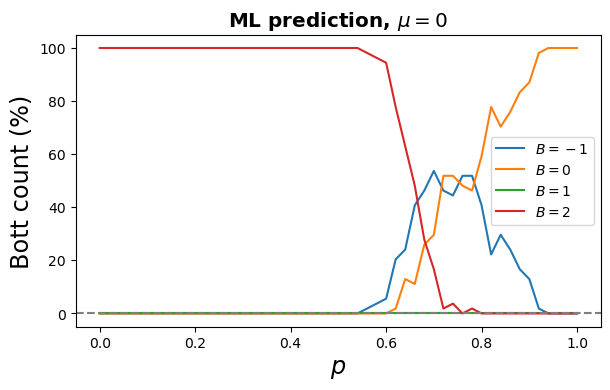

In [4]:
def Plots(Bott_density2,Bott_all2):
    min_Bott=int(np.nanmin(Bott_all2))
    max_Bott=int(np.nanmax(Bott_all2))
        
    #values of chimical potential mu:
    mu_step=1    
    mu_values=range(-7, 0+mu_step, mu_step)
    
    count_Bott=np.zeros((len(mu_values),N_p,max_Bott-min_Bott+1)) 
    B_values=range(min_Bott,max_Bott+1)
    for bval in range(-min_Bott+max_Bott+1):
        count_Bott[:,:,bval] = np.count_nonzero(Bott_all2[np.where(np.in1d(np.unique(mu_predict),mu_values))[0]] == B_values[bval], axis=2) 
    
    plt.figure(figsize=(7,4))
    plt.imshow(np.transpose(Bott_density2[:,:]), extent=[min(mu_predict),max(mu_predict),min(p_predict),max(p_predict)],aspect='auto',origin='lower',cmap='seismic',vmin=-2, vmax=2) 
    plt.plot(np.arange(mu_c1,mu_c2+0.1,0.01),fit_dome1(np.arange(mu_c1,mu_c2+0.1,0.01)),'k--')
    plt.plot(np.arange(mu_c3,0,0.01),fit_dome2(np.arange(mu_c3,0,0.01)),'k--')
    plt.colorbar()
    plt.ylim(0,1)
    plt.title('ML prediction - Bott index', fontweight ="bold",loc='center')
    plt.xlabel('$\\mu$', fontsize='xx-large')
    plt.ylabel("$p$", fontsize='xx-large')
    plt.subplots_adjust(left=0.15)  
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('Data/fig.png') 
    
    for mu_i in range(len(mu_values)): 
        plt.subplots(figsize=(7,4))
        for nn in range(max_Bott-min_Bott+1):
            plt.plot(np.unique(p_predict),100*count_Bott[mu_i,:,nn]/N_d, label='$B={}$'.format(B_values[nn])) 
        plt.title('ML prediction, $\\mu={}$'.format(mu_values[mu_i]), fontsize='x-large',  fontweight ="bold")
        plt.legend(loc='right')
        plt.axhline(y = 0, color = 'tab:gray', linestyle = '--')
        plt.xlabel('$p$', fontsize='xx-large')
        plt.ylabel("Bott count (%)", fontsize='xx-large')
        plt.subplots_adjust(left=0.15)  
        plt.subplots_adjust(bottom=0.15)
        plt.savefig('Data/f{}.png'.format(mu_i+1))   

Plots(Bott_density,Bott_all)

The first figure shows the phase diagram. The Bott index should be B=0 above the black dashed lines and nonzero below them. These dashed lines represent topological transitions that we extracted from  [Phys. Rev. B 100, 235102 (2019)]. The model prediction is good in the B=-1 phase. But the B=2 area is larger than it should be. Moreover, the last figure shows that, for mu=0, there is an interval of p values with a finite number of B=-1 counts. There should be no such interval with B=-1 for this value of mu.

## RandomForest

Next we try a RandomForest algorithm.

              precision    recall  f1-score   support

        -1.0       1.00      0.99      0.99        98
         0.0       0.99      0.99      0.99        70
         2.0       0.98      1.00      0.99        43

    accuracy                           0.99       211
   macro avg       0.99      0.99      0.99       211
weighted avg       0.99      0.99      0.99       211



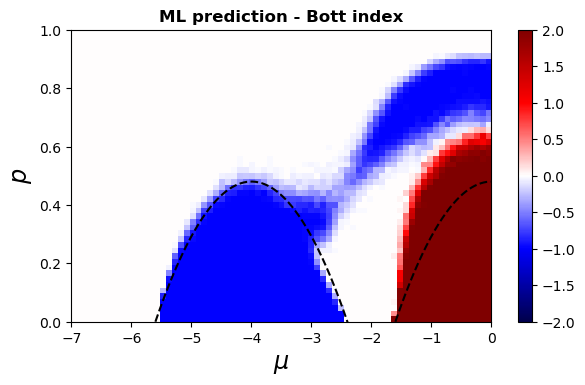

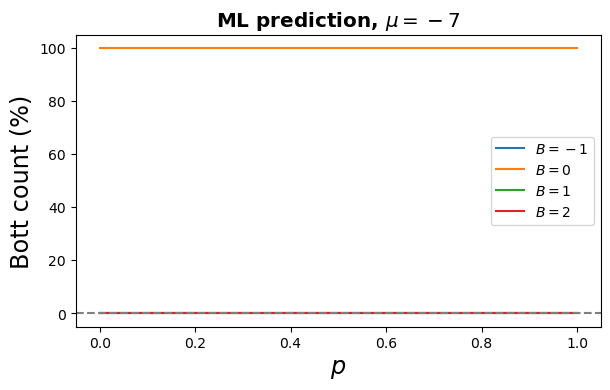

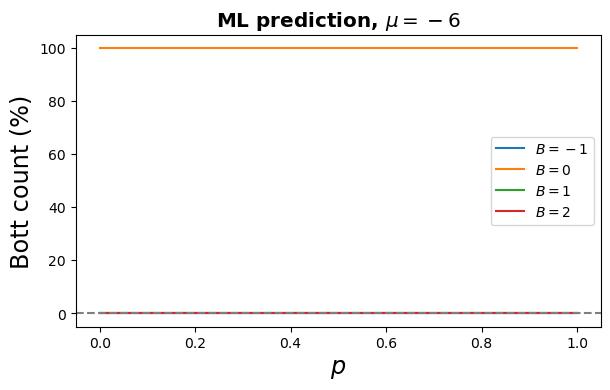

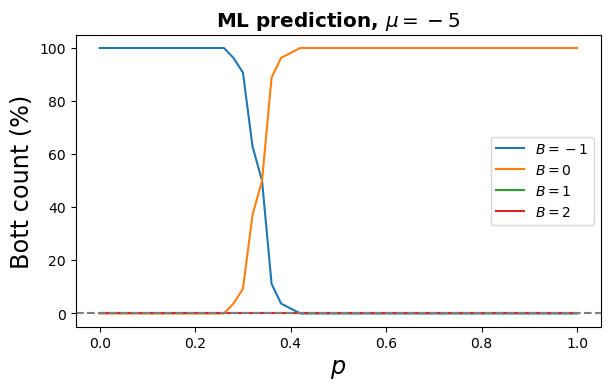

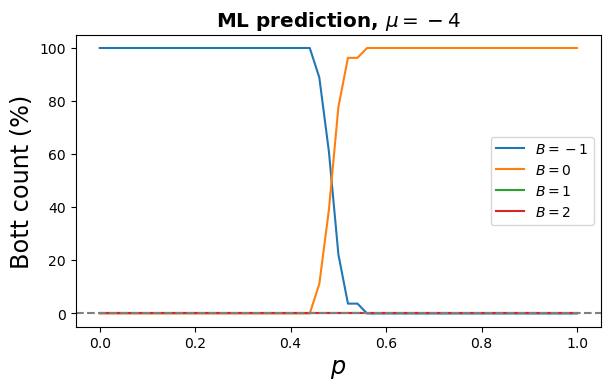

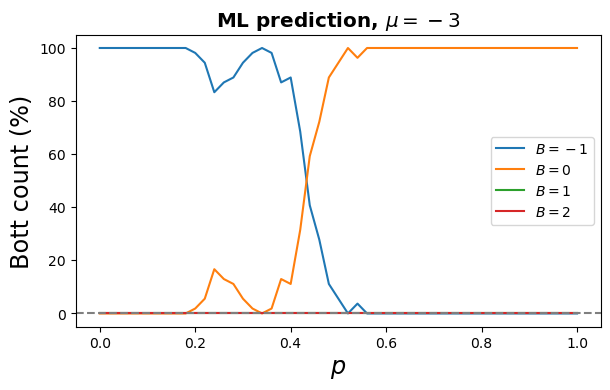

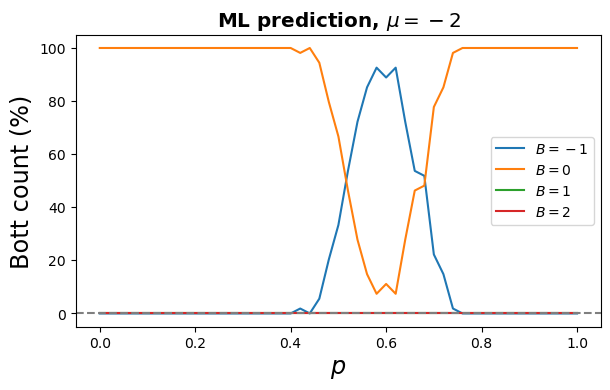

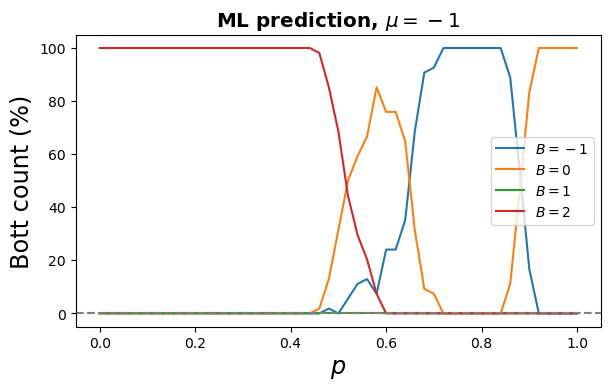

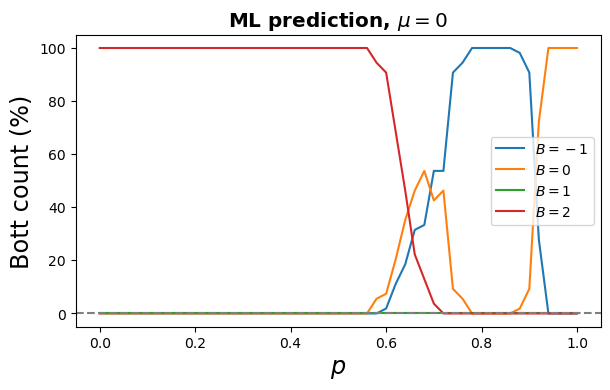

In [5]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

Bott_density,Bott_all=Predict_Classification(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

The result with RandomForest is worse than the one using LogisticRegression.

## Train a deep learning model

Next we use tensorflow to train different deep neural network (DNN) models. We start by considering the case with no hidden neuron layer.

2023-12-05 16:37:51.781416: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 16:37:51.855915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 16:37:51.855963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 16:37:51.857358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 16:37:51.867192: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 16:37:51.867657: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/25
49/49 [==============================] - 1s 9ms/step - loss: 1.0345 - accuracy: 0.4143 - val_loss: 1.0104 - val_accuracy: 0.4645
Epoch 2/25
49/49 [==============================] - 0s 4ms/step - loss: 0.9678 - accuracy: 0.4796 - val_loss: 0.9591 - val_accuracy: 0.4645
Epoch 3/25
49/49 [==============================] - 0s 4ms/step - loss: 0.9197 - accuracy: 0.6327 - val_loss: 0.9204 - val_accuracy: 0.6588
Epoch 4/25
49/49 [==============================] - 0s 4ms/step - loss: 0.8800 - accuracy: 0.7653 - val_loss: 0.8792 - val_accuracy: 0.7915
Epoch 5/25
49/49 [==============================] - 0s 4ms/step - loss: 0.8462 - accuracy: 0.7510 - val_loss: 0.8454 - val_accuracy: 0.9147
Epoch 6/25
49/49 [==============================] - 0s 4ms/step - loss: 0.8139 - accuracy: 0.9041 - val_loss: 0.8133 - val_accuracy: 0.8957
Epoch 7/25
49/49 [==============================] - 0s 4ms/step - loss: 0.7876 - accuracy: 0.8837 - val_loss: 0.7929 - val_accuracy: 0.9242
Epoch 8/25
49/49 [==

2023-12-05 16:38:03.300139: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 703922400 exceeds 10% of free system memory.


6111/6111 [==============================] - 14s 2ms/step


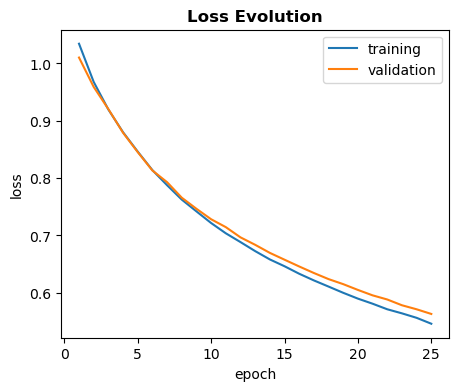

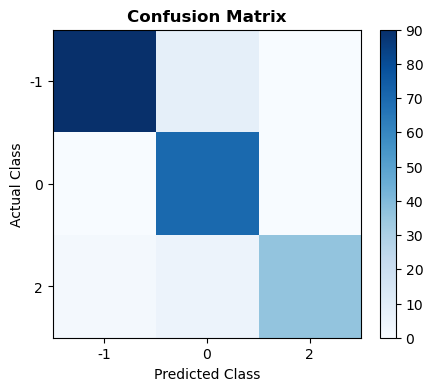

In [6]:
#Change data format to classes [0,1,2]:
y=np.where(y_t==0,1,y_t)
y=np.where(y==-1,0,y)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 

n_features=len(X[0,:]) # Number of features

#No hidden layer
model = Sequential()
model.add(Dense(3, input_dim=n_features, activation='softmax')) 

learning_rate2 = 0.001 #hyper-parameters for optimizer
num_epochs = 25 
batch_size2=10
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 


def Predict_DNN(model2,X_test2,y_test2):
    
    class_probabilities=model2.predict(X_test2)
    predictions=np.argmax(class_probabilities, axis=1)
    
    # Plot the Loss Evolution
    plt.figure(figsize=(5,4))
    epoch_nums = range(1,num_epochs+1)
    training_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.title('Loss Evolution', fontweight ="bold",loc='center')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.savefig('Data/g1.png')
    
    # Plot the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    classes=['-1','0','2']
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_test2, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix', fontweight ="bold",loc='center')
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.savefig('Data/g2.png')
    
    #Next we make predictions with the model:
    Bott_all2=np.zeros((N_mu,N_p,N_d)) 
    Bott_density2=np.zeros((N_mu,N_p)) 
    Bott_class = model2.predict(X_predict.astype('float32')) 
 
    for i_mu,mu_i in enumerate(np.unique(mu_predict)):
        for i_p,p_i in  enumerate(np.unique(p_predict)):
            var=np.intersect1d(np.where(mu_predict==mu_i),np.where(p_predict==p_i))
            Bott_t=np.argmax(Bott_class[var], axis=1)
            Bott_t=np.where(Bott_t==0,-1,Bott_t)#Change format from classes to actual Bott index.
            Bott_t=np.where(Bott_t==1,0,Bott_t)
            Bott_density2[i_mu,i_p]=Bott_t.mean()
            Bott_all2[i_mu,i_p,:]=Bott_t[:]

    return Bott_density2,Bott_all2

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test)

We see that the loss is not small enough. Anyway, let us see the predictions.

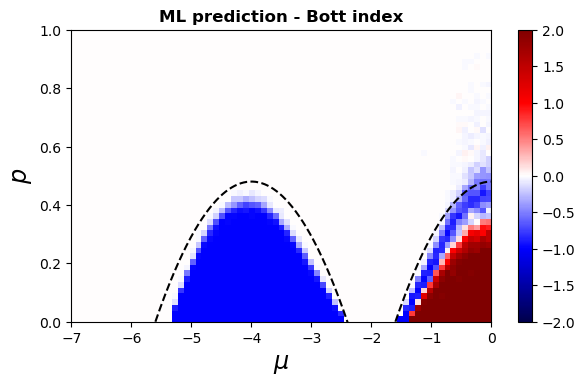

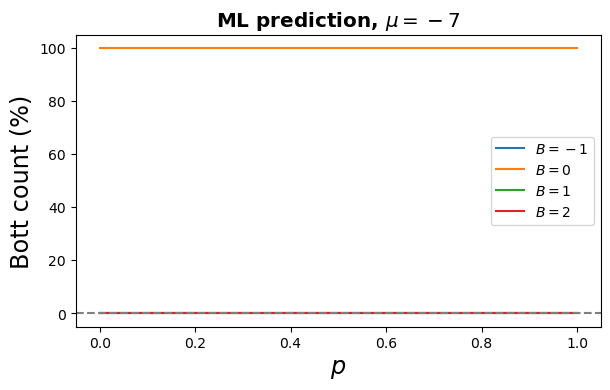

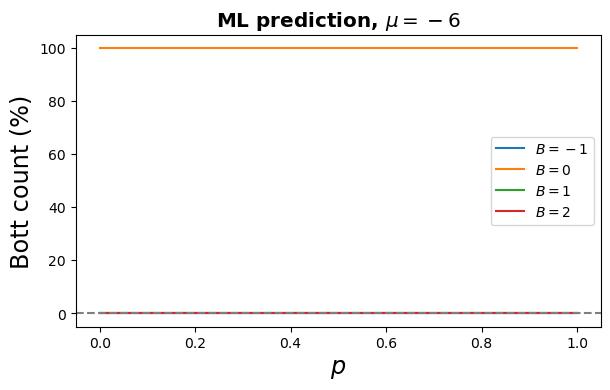

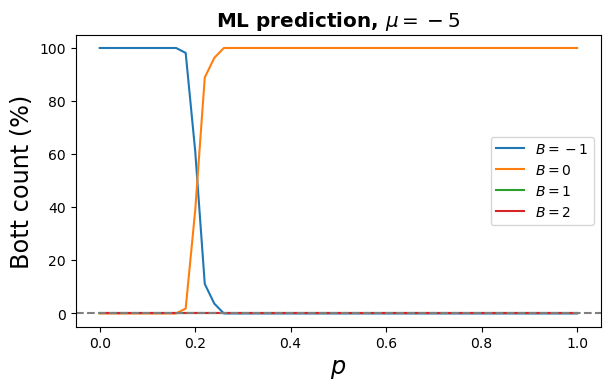

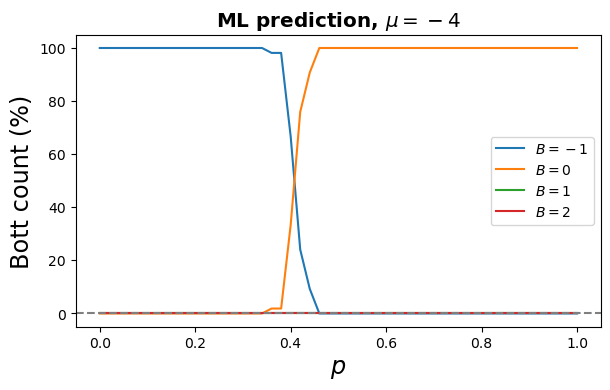

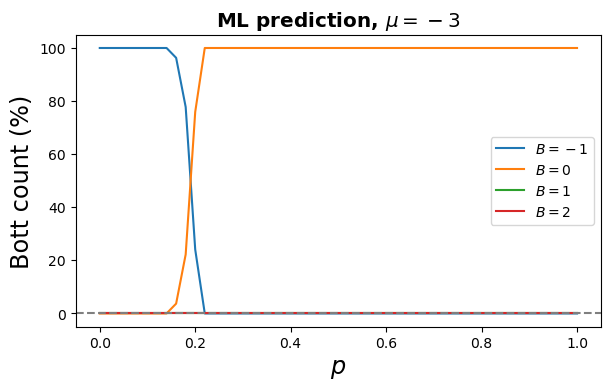

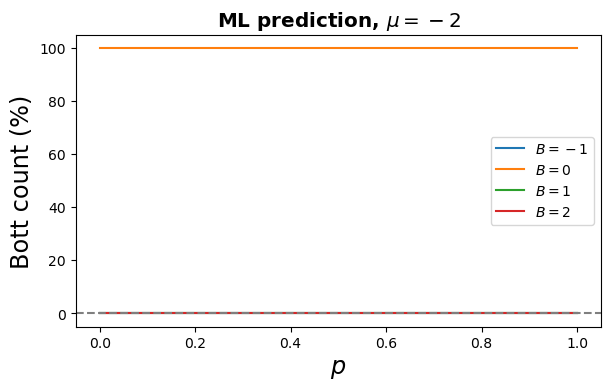

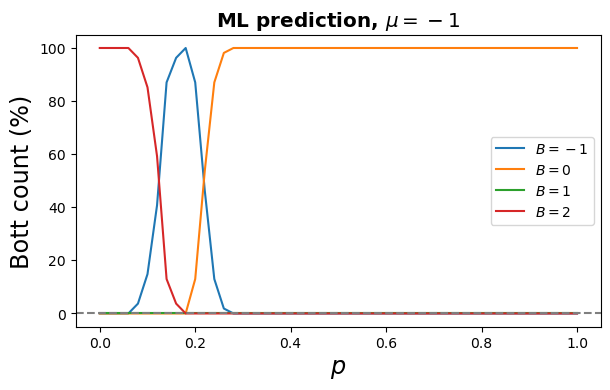

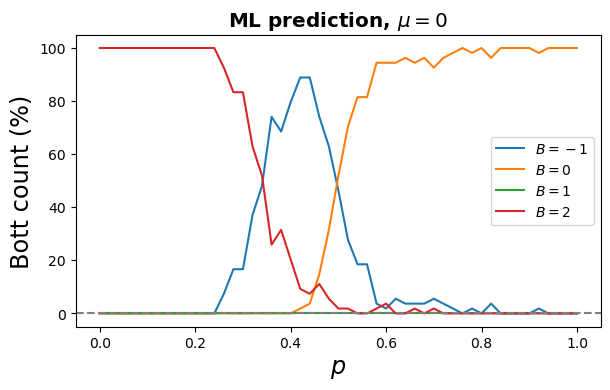

In [7]:
Plots(Bott_density,Bott_all)

The model predicted the Bott index to be B=-1 in regions it should be B=2. Let's try to improve the model increasing the number of epochs.

Epoch 1/100
49/49 [==============================] - 1s 8ms/step - loss: 1.0388 - accuracy: 0.4755 - val_loss: 1.0099 - val_accuracy: 0.4645
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 0.9678 - accuracy: 0.4816 - val_loss: 0.9611 - val_accuracy: 0.5924
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 0.9209 - accuracy: 0.7327 - val_loss: 0.9132 - val_accuracy: 0.7536
Epoch 4/100
49/49 [==============================] - 0s 4ms/step - loss: 0.8790 - accuracy: 0.7612 - val_loss: 0.8783 - val_accuracy: 0.7630
Epoch 5/100
49/49 [==============================] - 0s 5ms/step - loss: 0.8471 - accuracy: 0.7714 - val_loss: 0.8429 - val_accuracy: 0.9147
Epoch 6/100
49/49 [==============================] - 0s 4ms/step - loss: 0.8125 - accuracy: 0.9102 - val_loss: 0.8158 - val_accuracy: 0.9147
Epoch 7/100
49/49 [==============================] - 0s 4ms/step - loss: 0.7873 - accuracy: 0.8306 - val_loss: 0.7886 - val_accuracy: 0.9147
Epoch 8/100
4

Epoch 59/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.9592 - val_loss: 0.3879 - val_accuracy: 0.9431
Epoch 60/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3672 - accuracy: 0.9571 - val_loss: 0.3847 - val_accuracy: 0.9431
Epoch 61/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.9551 - val_loss: 0.3818 - val_accuracy: 0.9431
Epoch 62/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3614 - accuracy: 0.9571 - val_loss: 0.3789 - val_accuracy: 0.9384
Epoch 63/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3574 - accuracy: 0.9571 - val_loss: 0.3744 - val_accuracy: 0.9431
Epoch 64/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3540 - accuracy: 0.9571 - val_loss: 0.3711 - val_accuracy: 0.9431
Epoch 65/100
49/49 [==============================] - 0s 4ms/step - loss: 0.3510 - accuracy: 0.9571 - val_loss: 0.3679 - val_accuracy: 0.9431
Epoch 

2023-12-05 16:38:53.958417: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 703922400 exceeds 10% of free system memory.


6111/6111 [==============================] - 14s 2ms/step


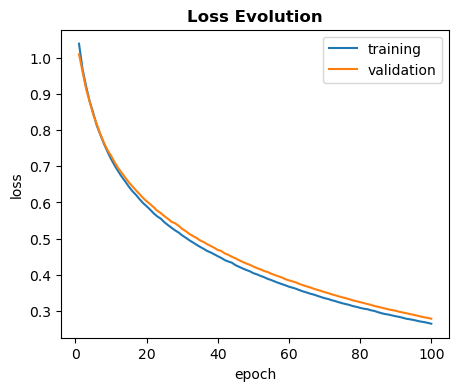

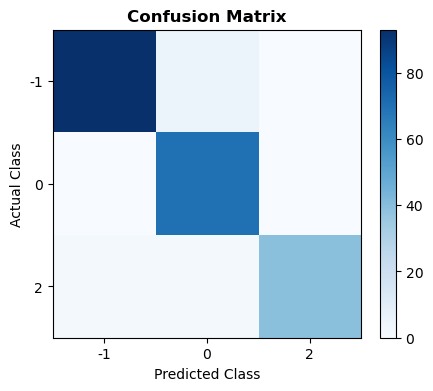

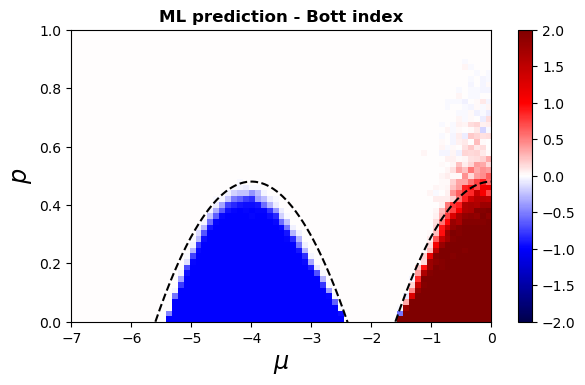

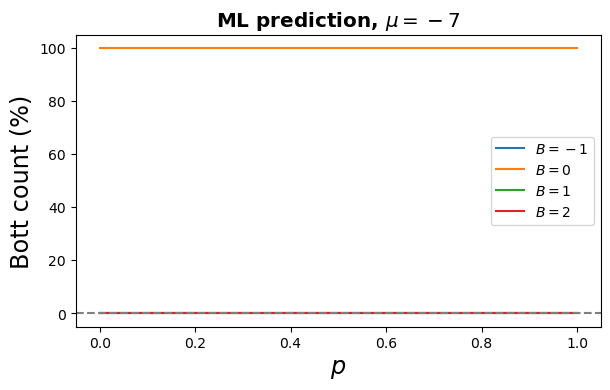

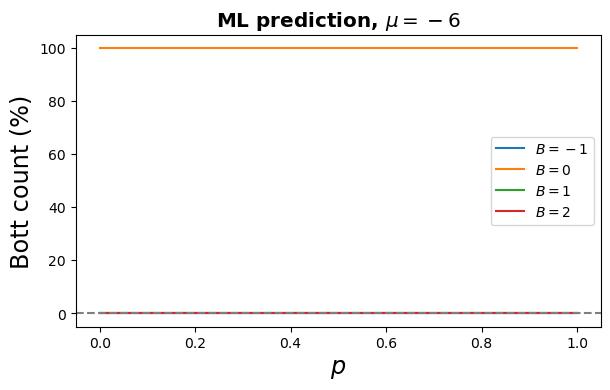

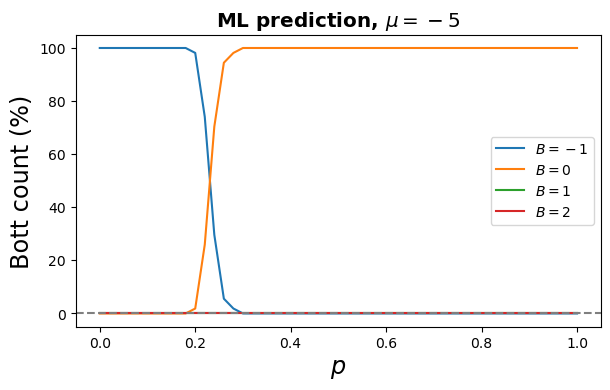

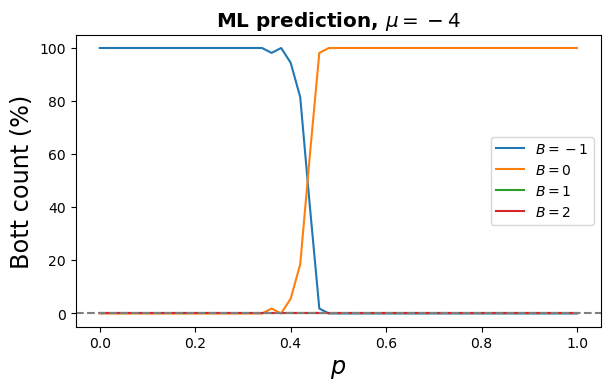

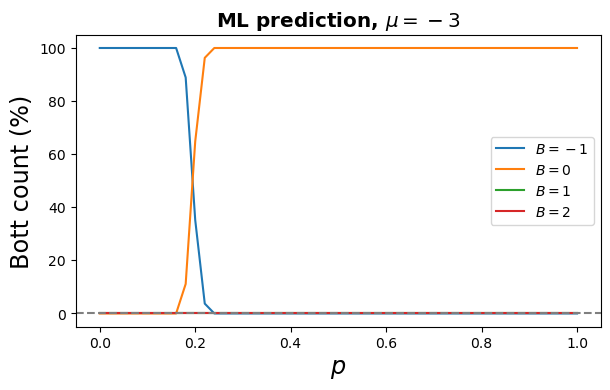

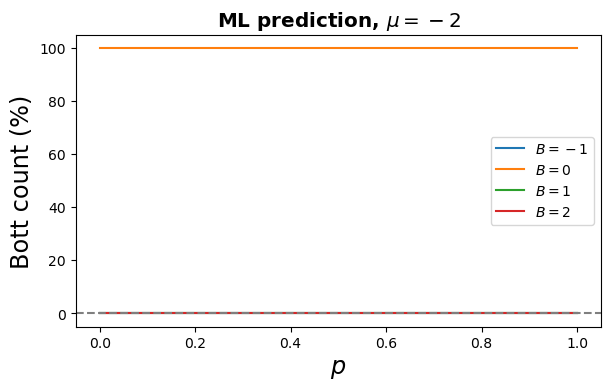

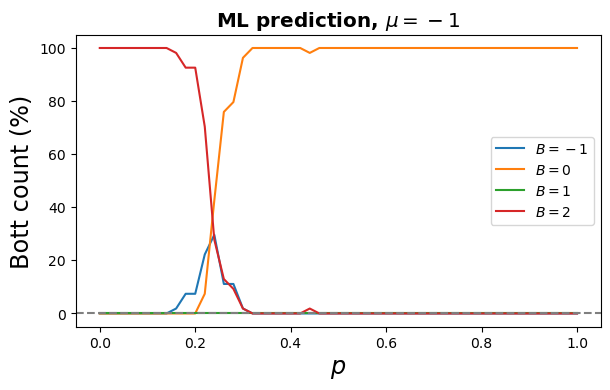

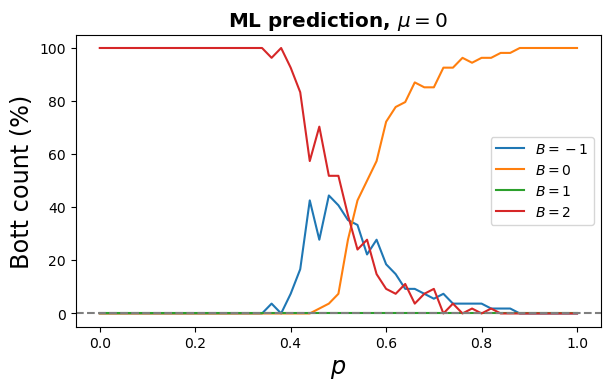

In [8]:
#No hidden layer and more epochs
model = Sequential()
model.add(Dense(3, input_dim=n_features, activation='softmax')) 

num_epochs = 100 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

Now we obtained a result better than the previous ones. In the following we check if we are able to obtain a result even better considering one hidden layer of neurons. Hidden neuron layers are able to capture nonlinear correlations between the labels and the features.

Epoch 1/25
49/49 [==============================] - 1s 17ms/step - loss: 0.8837 - accuracy: 0.5510 - val_loss: 0.7266 - val_accuracy: 0.6303
Epoch 2/25
49/49 [==============================] - 1s 13ms/step - loss: 0.6235 - accuracy: 0.8163 - val_loss: 0.5589 - val_accuracy: 0.8910
Epoch 3/25
49/49 [==============================] - 1s 13ms/step - loss: 0.4902 - accuracy: 0.9020 - val_loss: 0.4717 - val_accuracy: 0.9336
Epoch 4/25
49/49 [==============================] - 1s 13ms/step - loss: 0.3817 - accuracy: 0.9347 - val_loss: 0.3614 - val_accuracy: 0.9431
Epoch 5/25
49/49 [==============================] - 1s 13ms/step - loss: 0.2973 - accuracy: 0.9551 - val_loss: 0.2730 - val_accuracy: 0.9526
Epoch 6/25
49/49 [==============================] - 1s 13ms/step - loss: 0.2293 - accuracy: 0.9592 - val_loss: 0.2215 - val_accuracy: 0.9479
Epoch 7/25
49/49 [==============================] - 1s 13ms/step - loss: 0.1931 - accuracy: 0.9694 - val_loss: 0.1813 - val_accuracy: 0.9716
Epoch 8/25
49

2023-12-05 16:39:40.255515: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 703922400 exceeds 10% of free system memory.


6111/6111 [==============================] - 40s 7ms/step


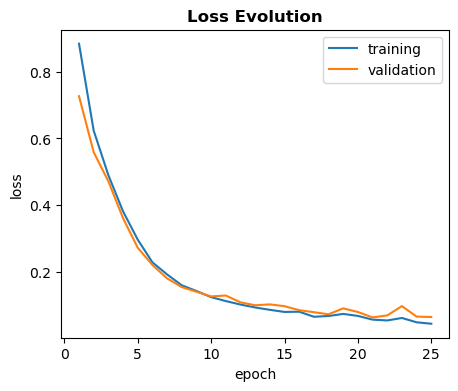

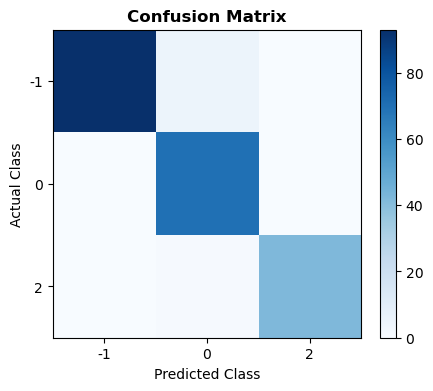

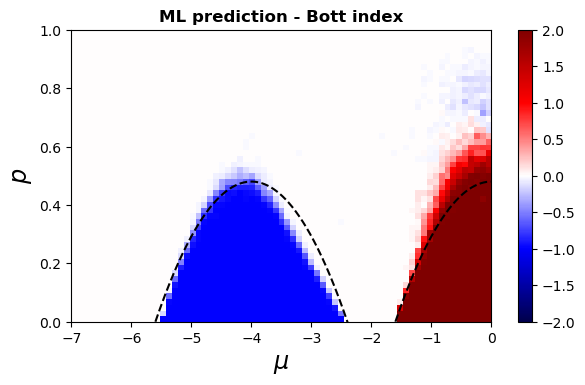

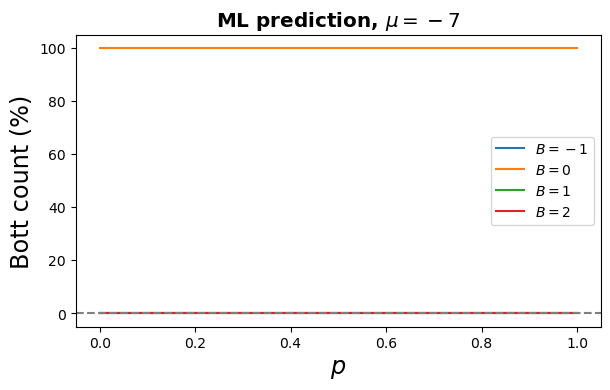

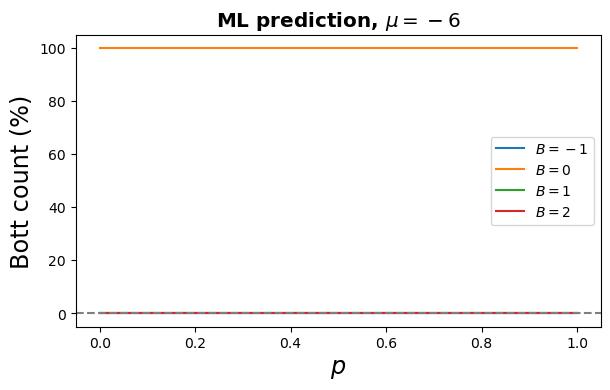

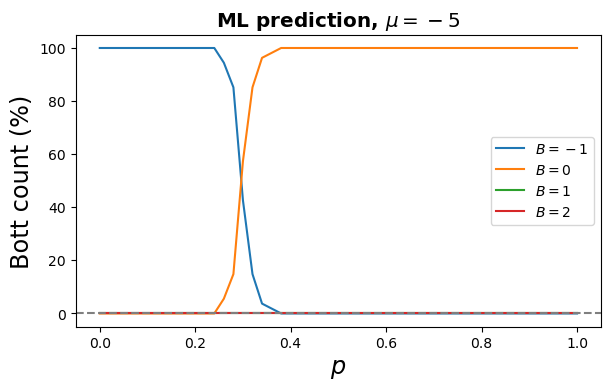

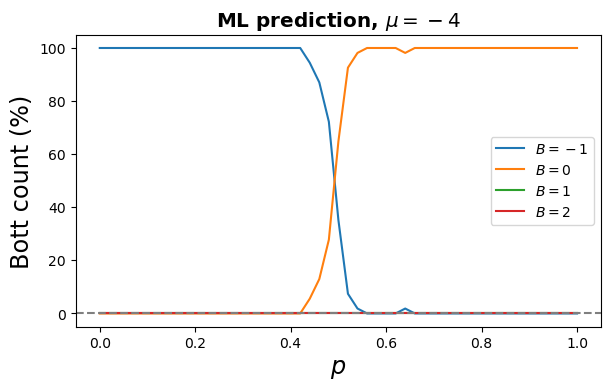

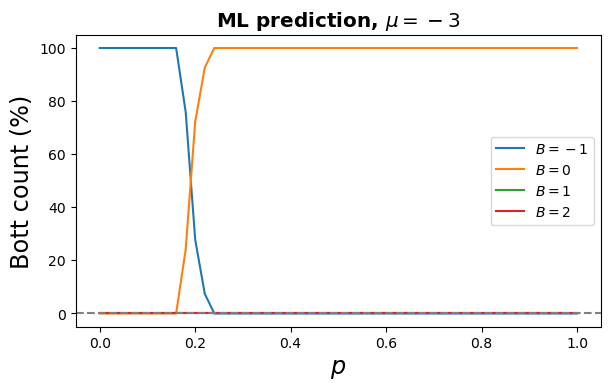

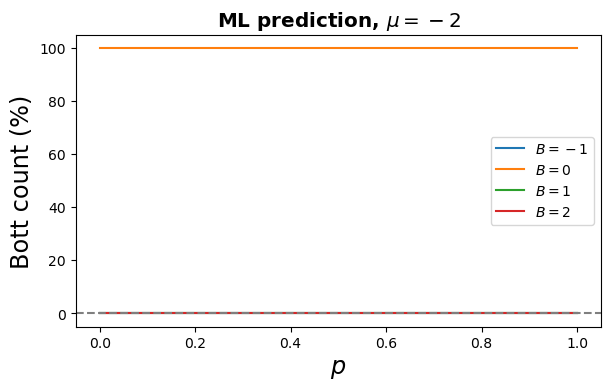

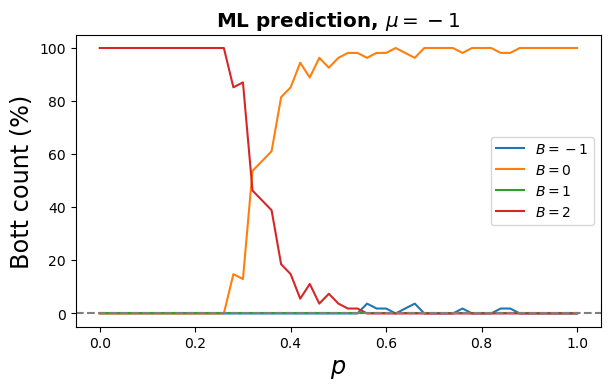

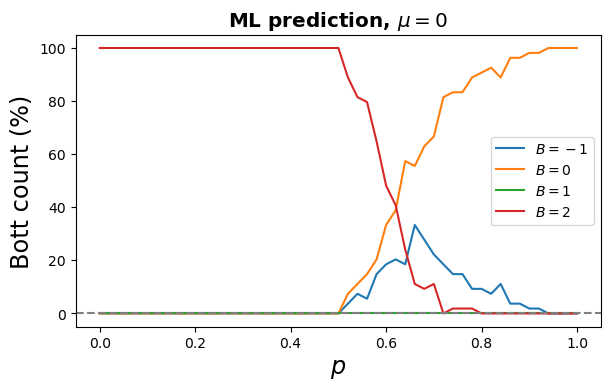

In [9]:
#One hidden layer
hl = int(2*n_features/3) # Number of hidden layer nodes
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 25 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)


The B=2 area is overestimated. Let's see the result with more epochs.

Epoch 1/100
49/49 [==============================] - 1s 17ms/step - loss: 0.8275 - accuracy: 0.6633 - val_loss: 0.6879 - val_accuracy: 0.9100
Epoch 2/100
49/49 [==============================] - 1s 13ms/step - loss: 0.5765 - accuracy: 0.8184 - val_loss: 0.5140 - val_accuracy: 0.9052
Epoch 3/100
49/49 [==============================] - 1s 13ms/step - loss: 0.4494 - accuracy: 0.9061 - val_loss: 0.4244 - val_accuracy: 0.9147
Epoch 4/100
49/49 [==============================] - 1s 13ms/step - loss: 0.3368 - accuracy: 0.9490 - val_loss: 0.3074 - val_accuracy: 0.9431
Epoch 5/100
49/49 [==============================] - 1s 13ms/step - loss: 0.2615 - accuracy: 0.9531 - val_loss: 0.2384 - val_accuracy: 0.9668
Epoch 6/100
49/49 [==============================] - 1s 13ms/step - loss: 0.2173 - accuracy: 0.9571 - val_loss: 0.2048 - val_accuracy: 0.9668
Epoch 7/100
49/49 [==============================] - 1s 13ms/step - loss: 0.1809 - accuracy: 0.9653 - val_loss: 0.1866 - val_accuracy: 0.9431
Epoch 

2023-12-05 16:41:40.510403: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 703922400 exceeds 10% of free system memory.


6111/6111 [==============================] - 41s 7ms/step


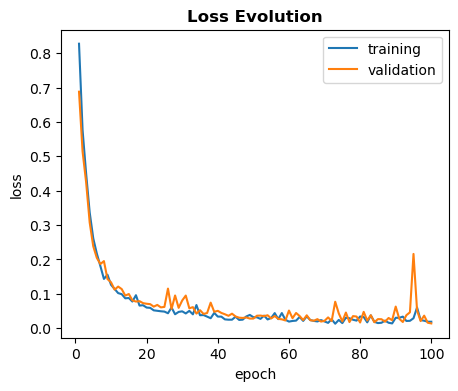

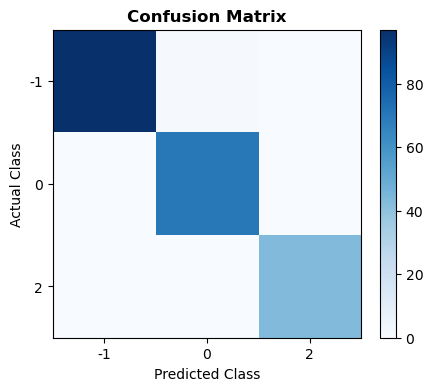

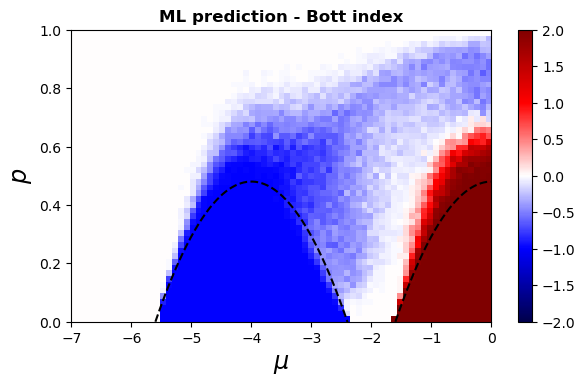

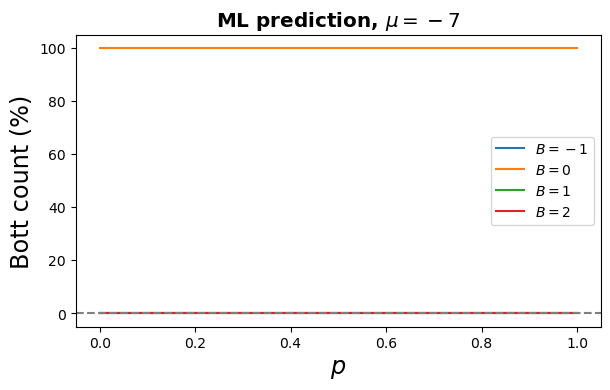

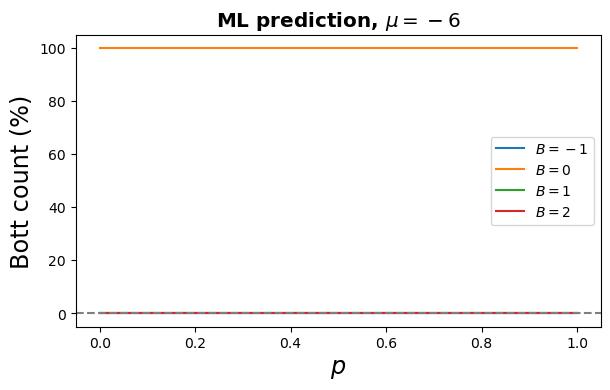

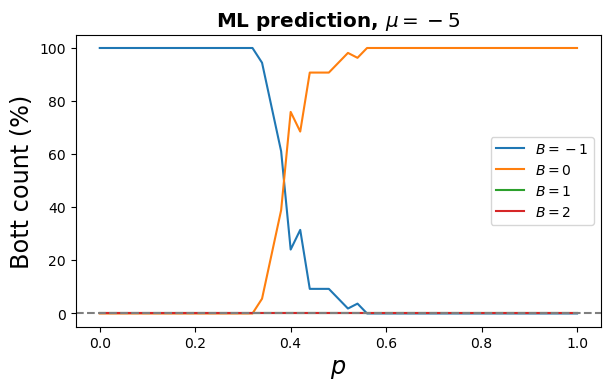

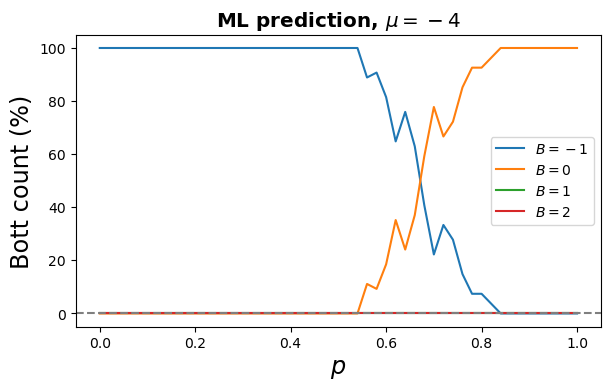

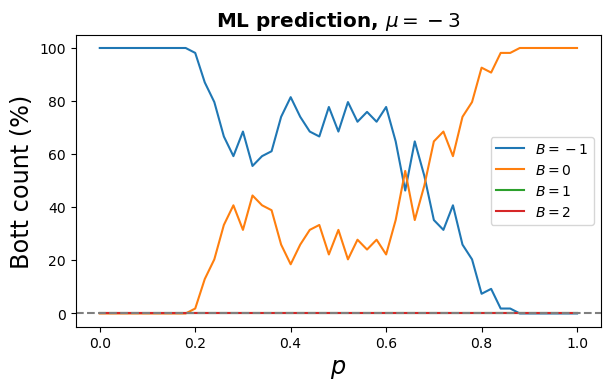

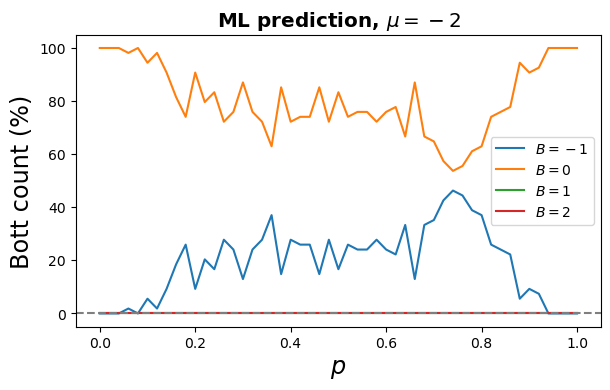

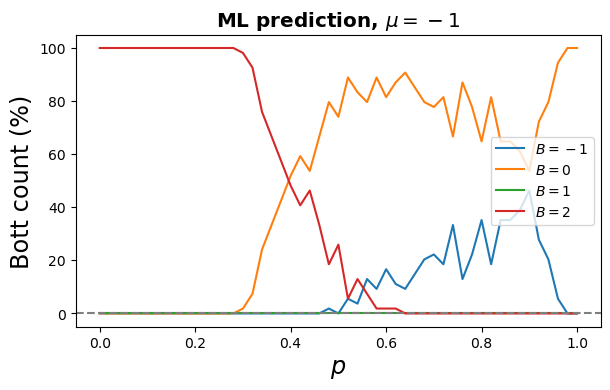

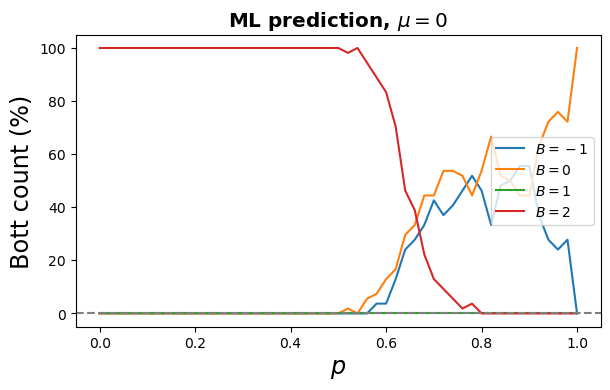

In [10]:
#One hidden layer and more epochs
hl = int(2*n_features/3) # Number of hidden layer nodes
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 100 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

The model predicts B=-1 in areas it should be B=0. We consider two hidden neuron layers in the following.

Epoch 1/25
49/49 [==============================] - 2s 24ms/step - loss: 0.7264 - accuracy: 0.6796 - val_loss: 0.5893 - val_accuracy: 0.5735
Epoch 2/25
49/49 [==============================] - 1s 21ms/step - loss: 0.4761 - accuracy: 0.8102 - val_loss: 0.4226 - val_accuracy: 0.8578
Epoch 3/25
49/49 [==============================] - 1s 20ms/step - loss: 0.2855 - accuracy: 0.9388 - val_loss: 0.2463 - val_accuracy: 0.9384
Epoch 4/25
49/49 [==============================] - 1s 21ms/step - loss: 0.1650 - accuracy: 0.9592 - val_loss: 0.1309 - val_accuracy: 0.9810
Epoch 5/25
49/49 [==============================] - 1s 20ms/step - loss: 0.1218 - accuracy: 0.9653 - val_loss: 0.1006 - val_accuracy: 0.9810
Epoch 6/25
49/49 [==============================] - 1s 21ms/step - loss: 0.0915 - accuracy: 0.9694 - val_loss: 0.0851 - val_accuracy: 0.9810
Epoch 7/25
49/49 [==============================] - 1s 21ms/step - loss: 0.0667 - accuracy: 0.9796 - val_loss: 0.0605 - val_accuracy: 0.9810
Epoch 8/25
49

2023-12-05 16:43:01.825939: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 703922400 exceeds 10% of free system memory.


6111/6111 [==============================] - 58s 9ms/step


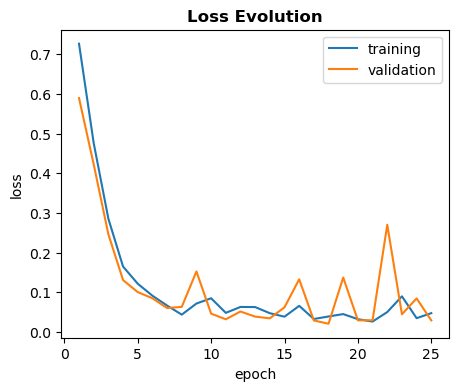

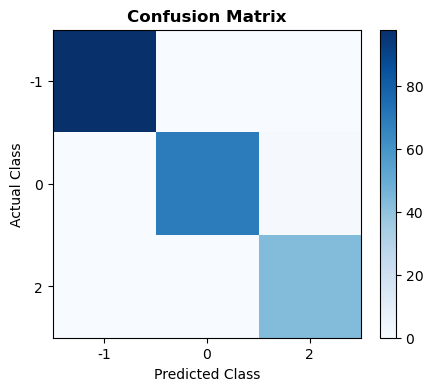

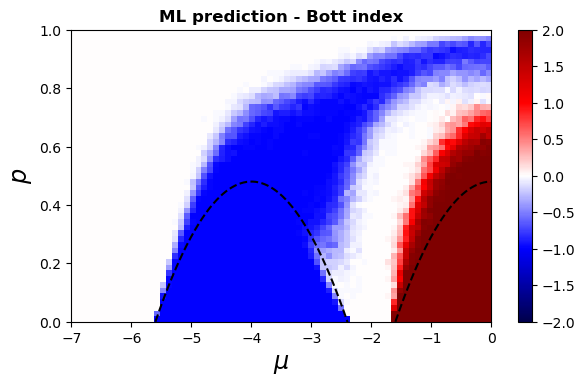

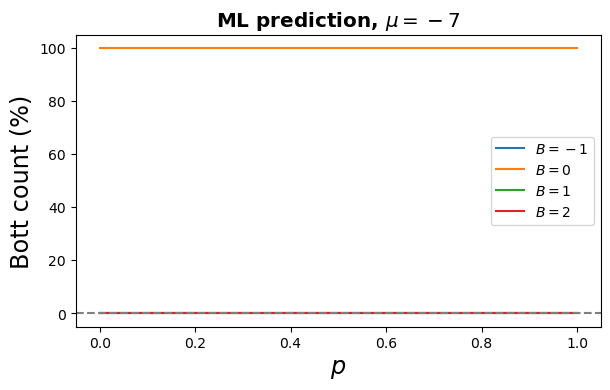

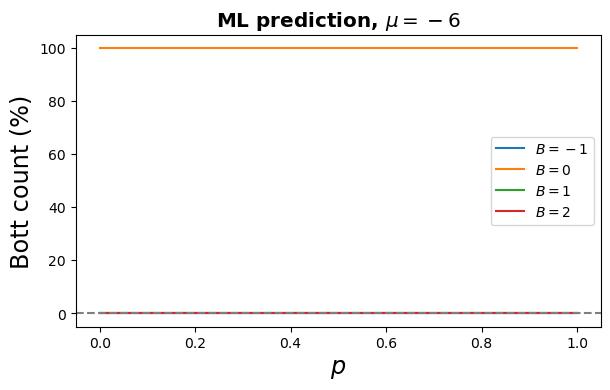

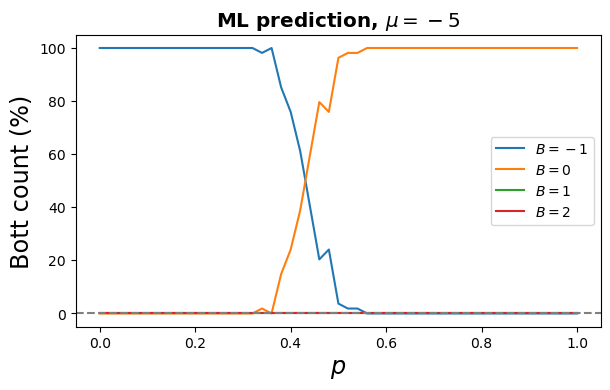

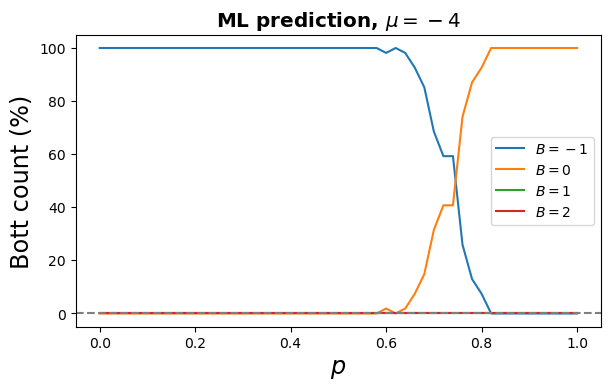

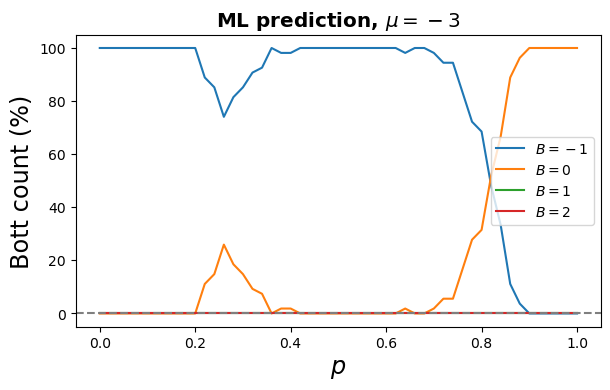

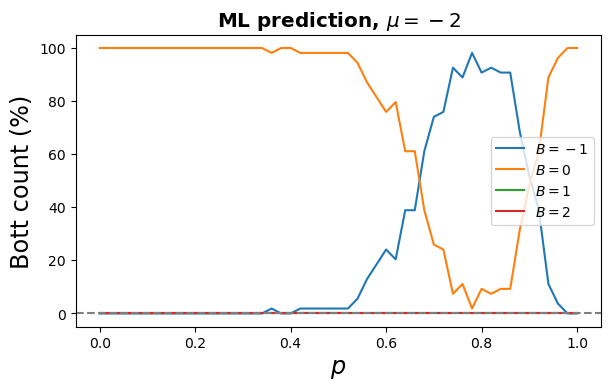

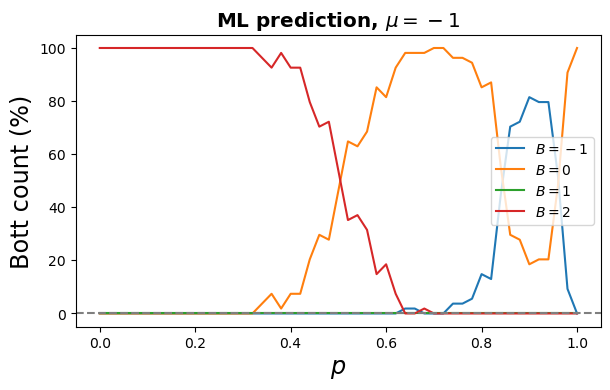

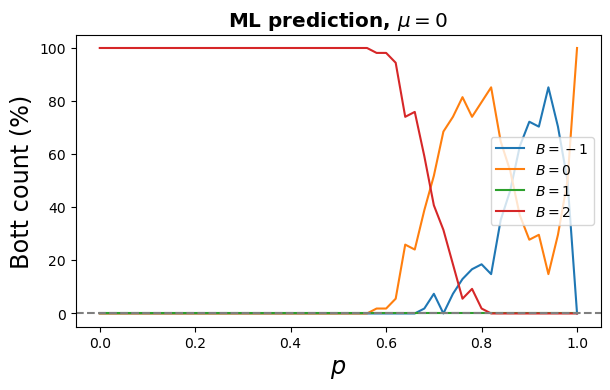

In [11]:
#Two hidden layers
hl = int(2*n_features/3) # Number of hidden layer nodes
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(hl, input_dim=hl, activation='relu'))
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 25 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

Let's try to improve the model with more epochs.

Epoch 1/100
49/49 [==============================] - 2s 25ms/step - loss: 0.7876 - accuracy: 0.5653 - val_loss: 0.6015 - val_accuracy: 0.8673
Epoch 2/100
49/49 [==============================] - 1s 21ms/step - loss: 0.5511 - accuracy: 0.8082 - val_loss: 0.4420 - val_accuracy: 0.9005
Epoch 3/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3289 - accuracy: 0.9388 - val_loss: 0.2459 - val_accuracy: 0.9336
Epoch 4/100
49/49 [==============================] - 1s 21ms/step - loss: 0.1866 - accuracy: 0.9469 - val_loss: 0.1219 - val_accuracy: 0.9810
Epoch 5/100
49/49 [==============================] - 1s 21ms/step - loss: 0.1032 - accuracy: 0.9755 - val_loss: 0.0782 - val_accuracy: 0.9810
Epoch 6/100
49/49 [==============================] - 1s 21ms/step - loss: 0.0872 - accuracy: 0.9694 - val_loss: 0.0684 - val_accuracy: 0.9810
Epoch 7/100
49/49 [==============================] - 1s 21ms/step - loss: 0.0680 - accuracy: 0.9796 - val_loss: 0.0546 - val_accuracy: 0.9810
Epoch 

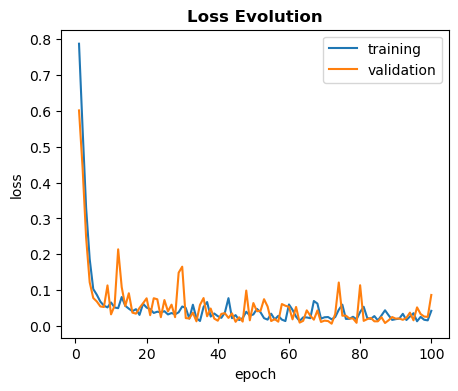

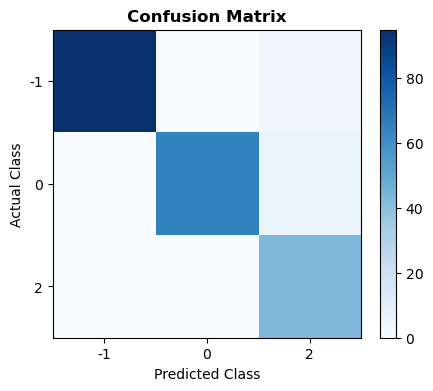

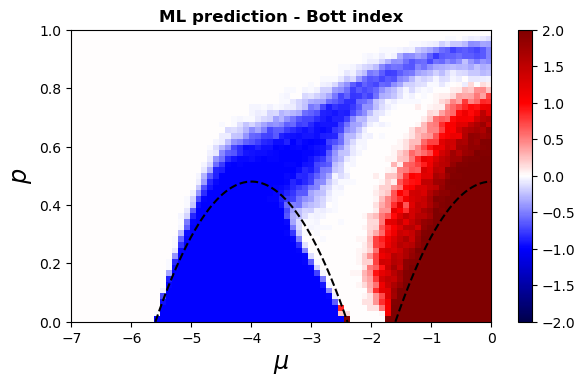

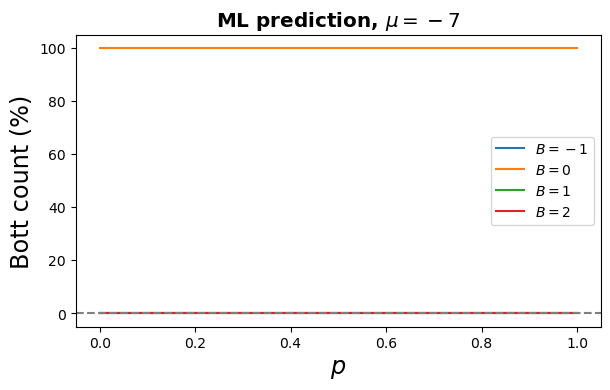

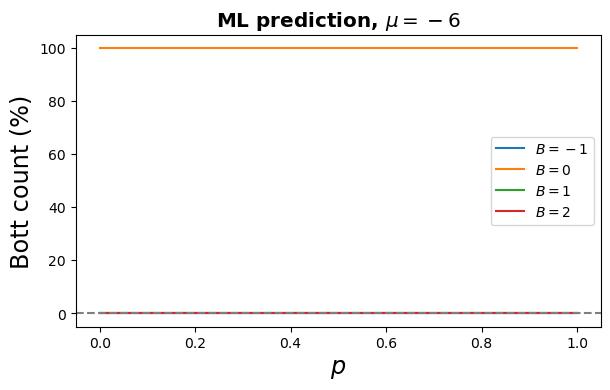

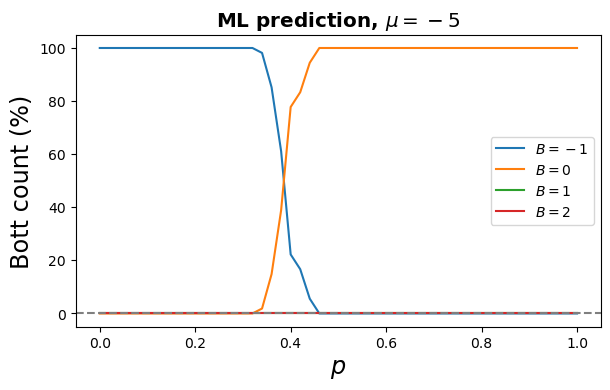

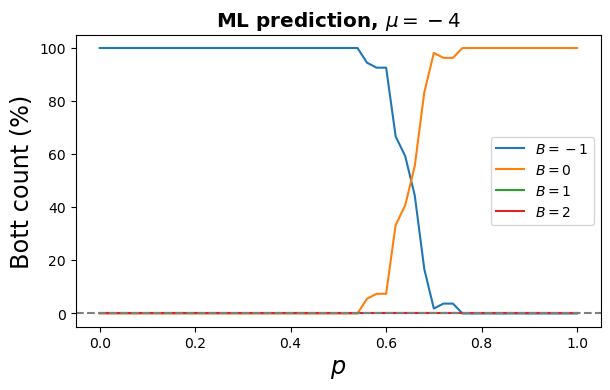

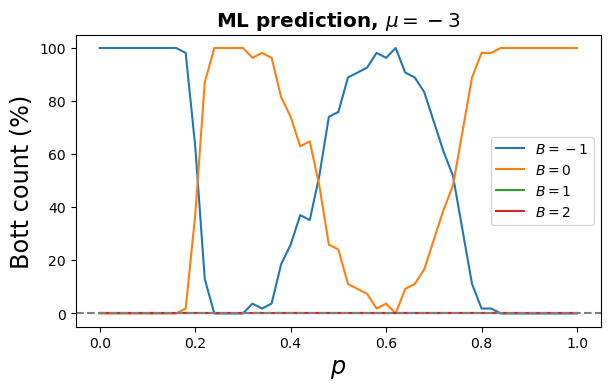

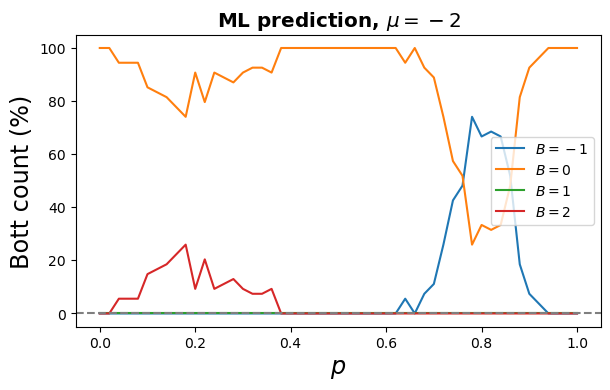

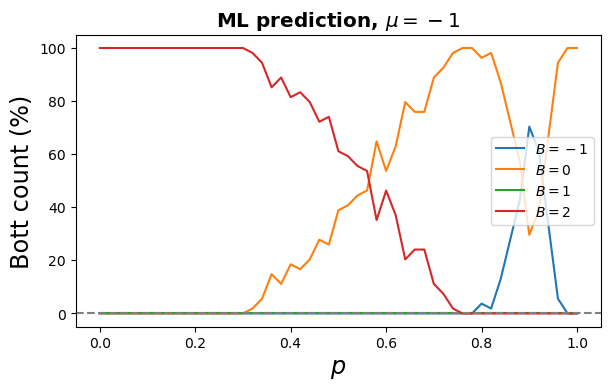

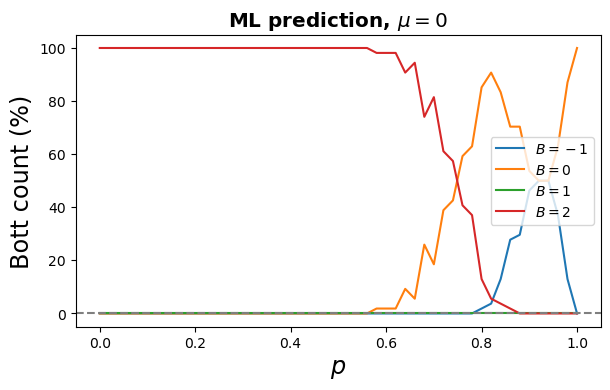

In [12]:
#Two hidden layers with more epochs
model = Sequential()
model.add(Dense(hl, input_dim=n_features, activation='relu')) 
model.add(Dense(hl, input_dim=hl, activation='relu'))
model.add(Dense(3, input_dim=hl, activation='softmax'))

num_epochs = 100 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

There is still a region with B=-1 where it should be B=0. The result with no hidden neuron layer was good enough. Let us consider again that model with more epochs and save it for future use.

Epoch 1/200
49/49 [==============================] - 1s 8ms/step - loss: 1.0454 - accuracy: 0.3939 - val_loss: 1.0171 - val_accuracy: 0.4645
Epoch 2/200
49/49 [==============================] - 0s 4ms/step - loss: 0.9735 - accuracy: 0.5102 - val_loss: 0.9705 - val_accuracy: 0.5877
Epoch 3/200
49/49 [==============================] - 0s 4ms/step - loss: 0.9254 - accuracy: 0.6776 - val_loss: 0.9236 - val_accuracy: 0.7725
Epoch 4/200
49/49 [==============================] - 0s 4ms/step - loss: 0.8834 - accuracy: 0.8184 - val_loss: 0.8815 - val_accuracy: 0.7630
Epoch 5/200
49/49 [==============================] - 0s 4ms/step - loss: 0.8477 - accuracy: 0.8306 - val_loss: 0.8480 - val_accuracy: 0.9100
Epoch 6/200
49/49 [==============================] - 0s 4ms/step - loss: 0.8154 - accuracy: 0.8735 - val_loss: 0.8155 - val_accuracy: 0.9052
Epoch 7/200
49/49 [==============================] - 0s 4ms/step - loss: 0.7881 - accuracy: 0.8959 - val_loss: 0.7898 - val_accuracy: 0.9005
Epoch 8/200
4

Epoch 59/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3707 - accuracy: 0.9551 - val_loss: 0.3876 - val_accuracy: 0.9431
Epoch 60/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3669 - accuracy: 0.9531 - val_loss: 0.3850 - val_accuracy: 0.9431
Epoch 61/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3641 - accuracy: 0.9612 - val_loss: 0.3807 - val_accuracy: 0.9431
Epoch 62/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3601 - accuracy: 0.9551 - val_loss: 0.3773 - val_accuracy: 0.9431
Epoch 63/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.9592 - val_loss: 0.3736 - val_accuracy: 0.9431
Epoch 64/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3536 - accuracy: 0.9612 - val_loss: 0.3704 - val_accuracy: 0.9431
Epoch 65/200
49/49 [==============================] - 0s 4ms/step - loss: 0.3500 - accuracy: 0.9592 - val_loss: 0.3671 - val_accuracy: 0.9431
Epoch 

49/49 [==============================] - 0s 4ms/step - loss: 0.1686 - accuracy: 0.9694 - val_loss: 0.1787 - val_accuracy: 0.9810
Epoch 174/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9694 - val_loss: 0.1777 - val_accuracy: 0.9810
Epoch 175/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9694 - val_loss: 0.1768 - val_accuracy: 0.9810
Epoch 176/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.9714 - val_loss: 0.1763 - val_accuracy: 0.9810
Epoch 177/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.9714 - val_loss: 0.1761 - val_accuracy: 0.9810
Epoch 178/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1641 - accuracy: 0.9714 - val_loss: 0.1747 - val_accuracy: 0.9810
Epoch 179/200
49/49 [==============================] - 0s 4ms/step - loss: 0.1632 - accuracy: 0.9694 - val_loss: 0.1738 - val_accuracy: 0.9810
Epoch 180/200

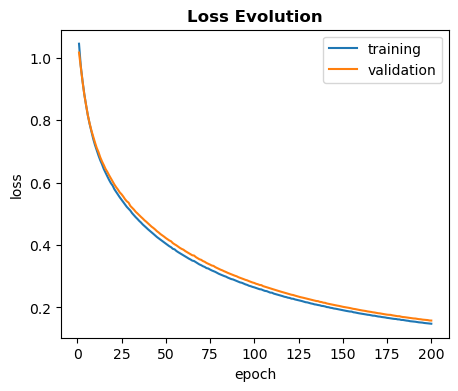

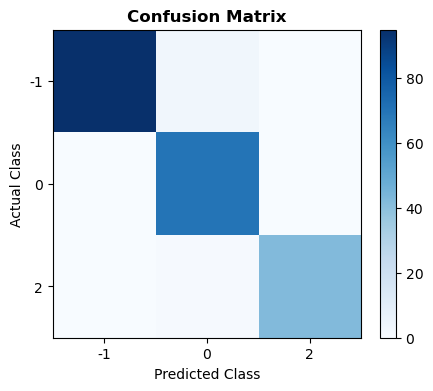

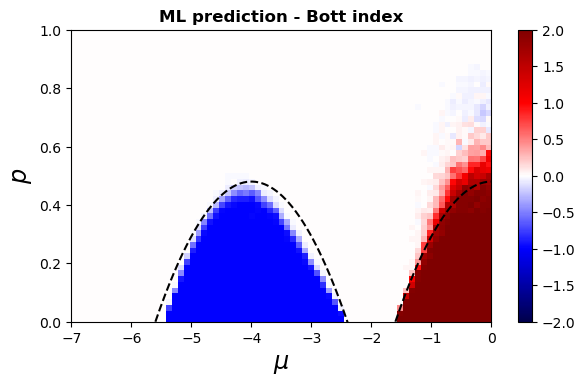

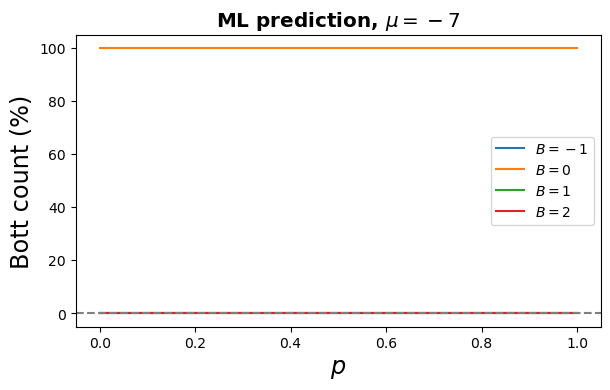

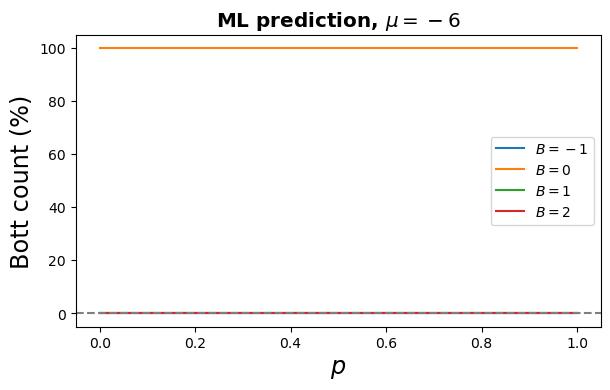

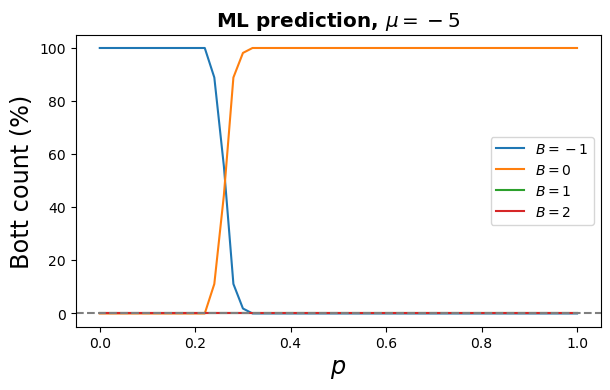

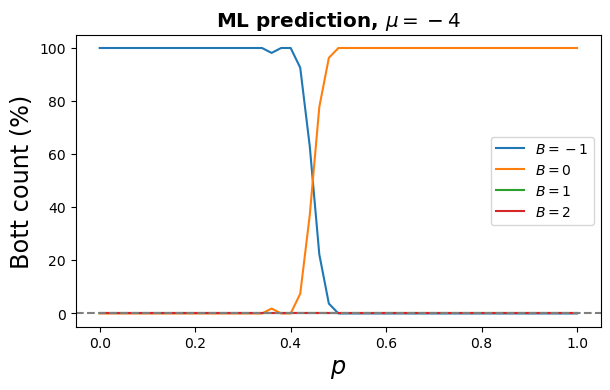

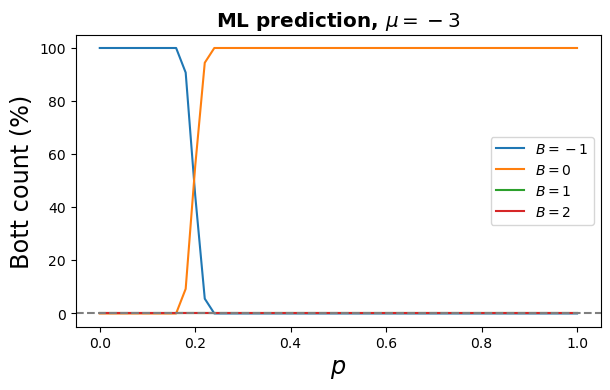

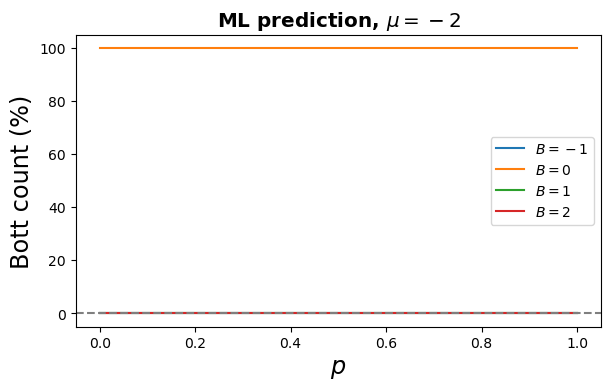

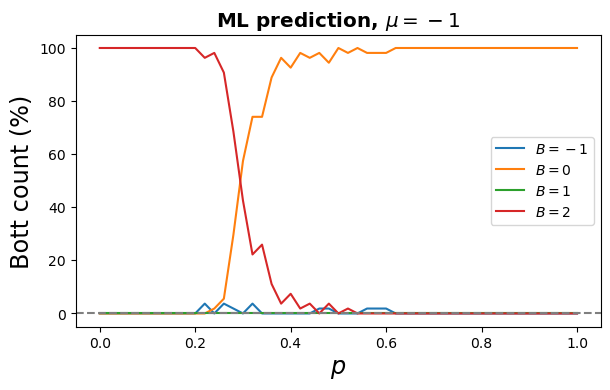

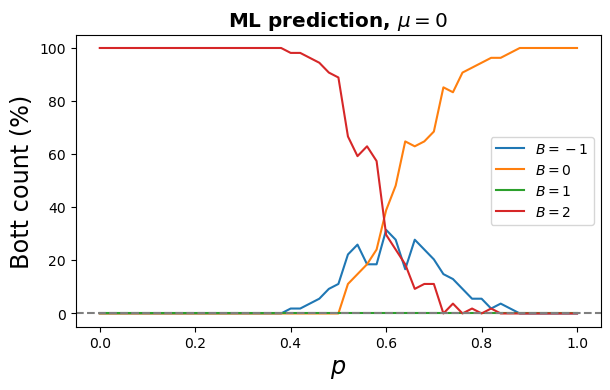

In [13]:
#No hidden layer and more epochs
model = Sequential()
model.add(Dense(3, input_dim=n_features, activation='softmax')) 

num_epochs = 200 
opt = optimizers.Adam(learning_rate=learning_rate2)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size2, validation_data=(X_test, y_test)) 

Bott_density,Bott_all=Predict_DNN(model,X_test,y_test) 
Plots(Bott_density,Bott_all)

# SAVE OR LOAD MODEL
modelFileName = 'Data/classifier_DNN.keras'
model.save(modelFileName)
# from tensorflow.keras import models
# model = models.load_model(modelFileName)

## Conclusion

Here we trained ML models to predict the topological Bott index of disordered superconductors. The training dataset consists of a small region of the total phase diagram, namely p=0. We fully recovered the phase diagram using different ML methods. The best method was based on neural networks with no hidden layer, indicating that the correlations between labels and features are linear. The precise calculation of the Bott index demands high computational resources and we are able to make quick accurate predictions of this topological index using ML methods, which require less computational resources.